In [28]:
import skimage
import imageio
import tifffile
import matplotlib.pyplot as plt
import pathlib
import numpy as np

In [72]:
def normalize_intensity(im):
    im = im.astype(np.float32)
    return (im - im.min()) / (im.max() - im.min())

In [ ]:
def autoscale(im, percentile=99.9):
    vmin, vmax = np.percentile(im, [100 - percentile, percentile])
    return skimage.exposure.rescale_intensity(im, in_range=(vmin, vmax))

In [70]:
def imshow(*ims, figsize=(12, 12)):
    plt.figure(figsize=figsize)
    ims = [normalize_intensity(im) for im in ims]
    plt.imshow(np.concatenate(ims, axis=1), cmap="gray")
    plt.axis("off")
    plt.show()

In [21]:
data_dirpath = pathlib.Path("../processed-data").absolute()
filepaths = [
    dirpath / filename
    for dirpath, _, filenames in data_dirpath.walk()
    for filename in filenames
    if filename.endswith(".tiff")
]
len(filepaths)

46

In [26]:
# Load all of the images.
raw_ims = [tifffile.imread(filepath) for filepath in filepaths]
len(raw_ims)

46

### Exploratory visualization

In [50]:
# Create min-intensity projections of all FOVs and stack them into a single array.
raw_ims_proj = np.stack([autoscale(im.min(axis=0)) for im in raw_ims])
raw_ims_pro.shape

(46, 512, 512)

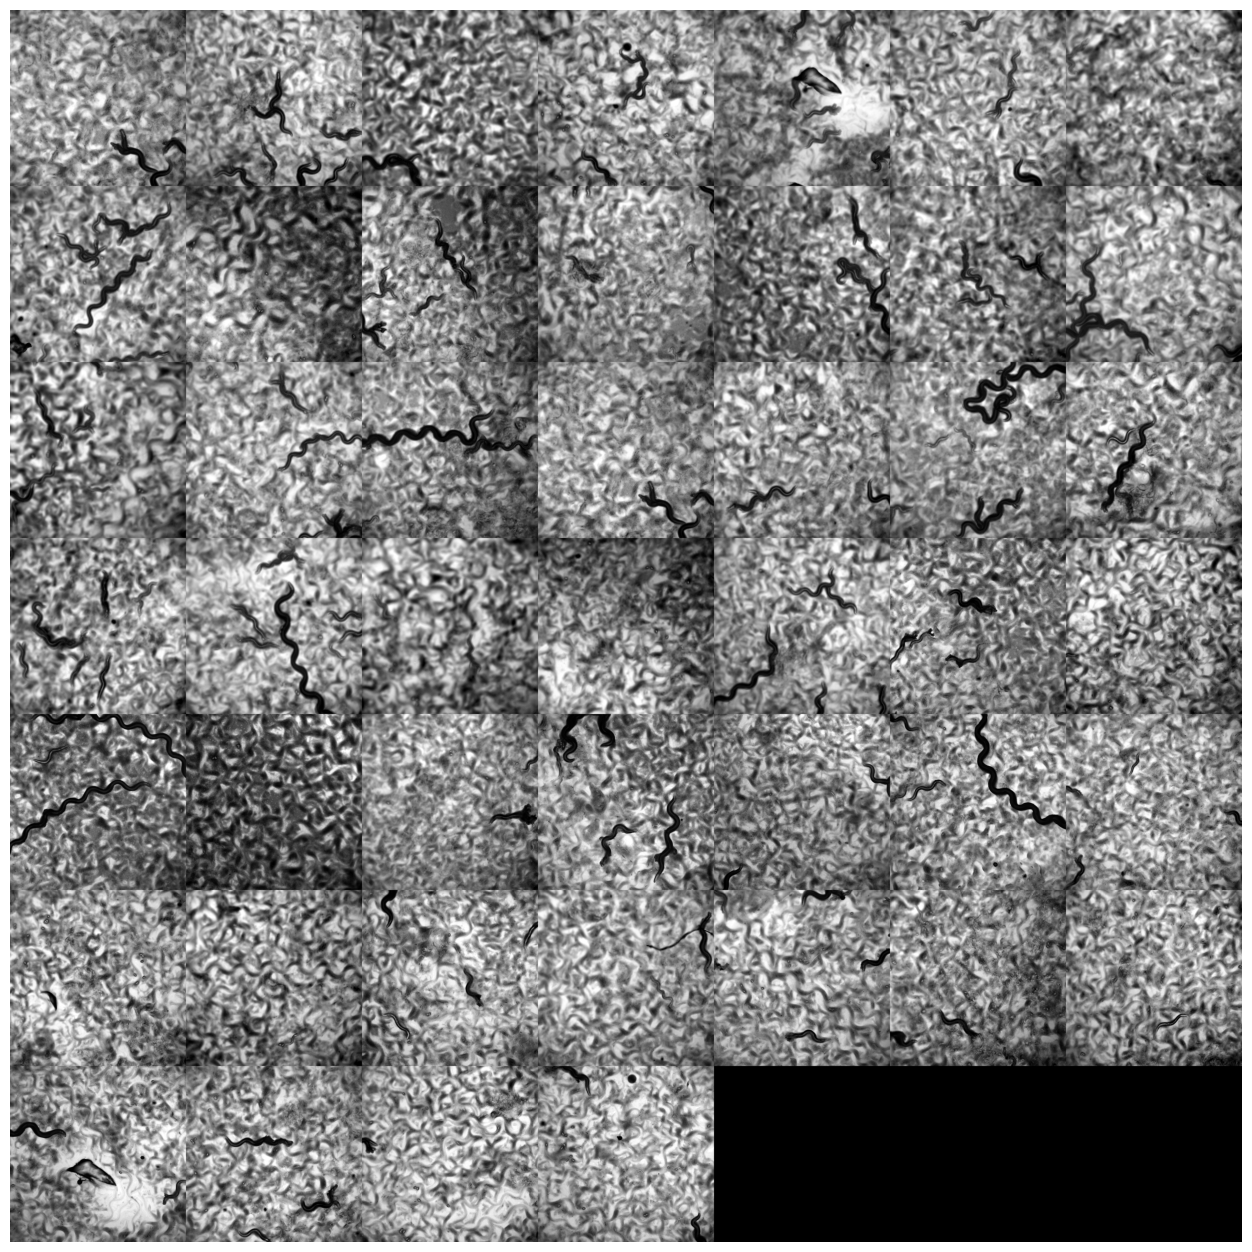

In [58]:
# Reshape the min-projections to a 2D tiled array.
n = 7
m = np.ceil(len(raw_ims_proj) / n).astype(int)

xy_size = raw_ims_proj.shape[1]

# Pad the array with zeros so that it is a multiple of n.
tiled_image = np.zeros((n * m, xy_size, xy_size), dtype=raw_ims_proj.dtype)
tiled_image[: len(raw_ims_proj)] = raw_ims_proj

tiled_image = (
    tiled_image.reshape(n, m, xy_size, xy_size)
    .transpose(0, 2, 1, 3)
    .reshape(n * xy_size, m * xy_size)
)

imshow(tiled_image, figsize=(16, 16))

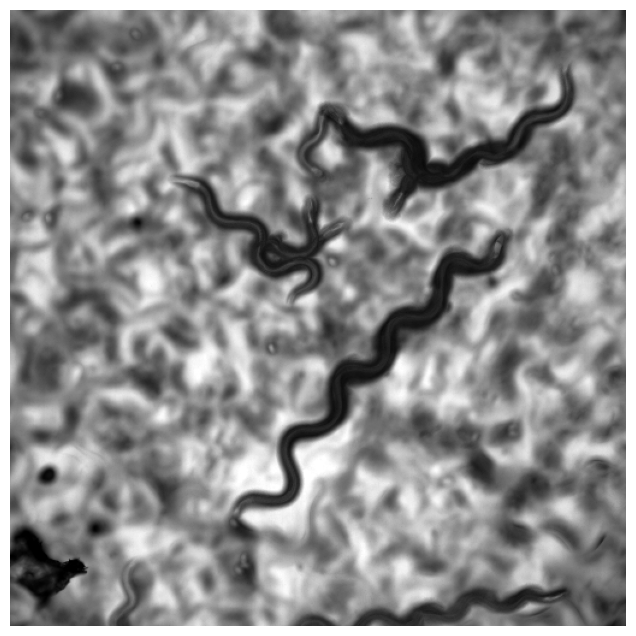

In [142]:
# Inspect single FOVs in the tiled array (I manually counted to figure out the index).
imshow(ims_proj[7, :, :], figsize=(8, 8))

### Generating a frame-wise background mask

In [ ]:
# Hand-picked examples of in-focus and out-of-focus images.
im_if = ims[16][100, :, :]
im_of = ims[7][100, :, :]

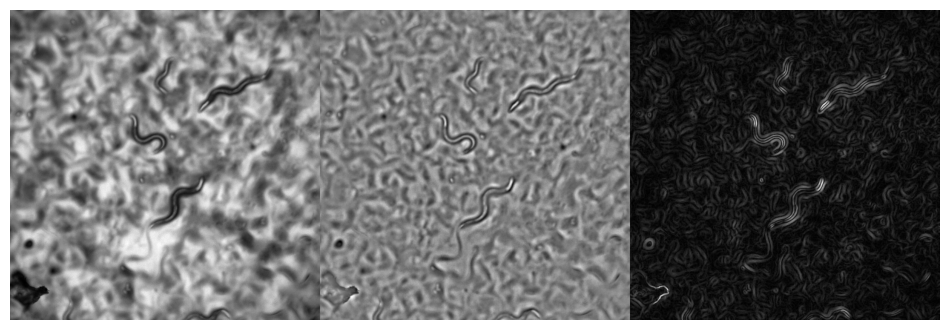

In [144]:
def difference_of_gaussians(im):
    """
    Difference of Gaussians to generate a mask of the background.
    """
    im_low_pass = skimage.filters.gaussian(im, sigma=5)
    im_high_pass = skimage.filters.gaussian(im, sigma=0.5)
    return im_high_pass - im_low_pass


im = im_of.copy()
im_dog = difference_of_gaussians(im)
imshow(im, im_dog, skimage.filters.sobel(im_dog))

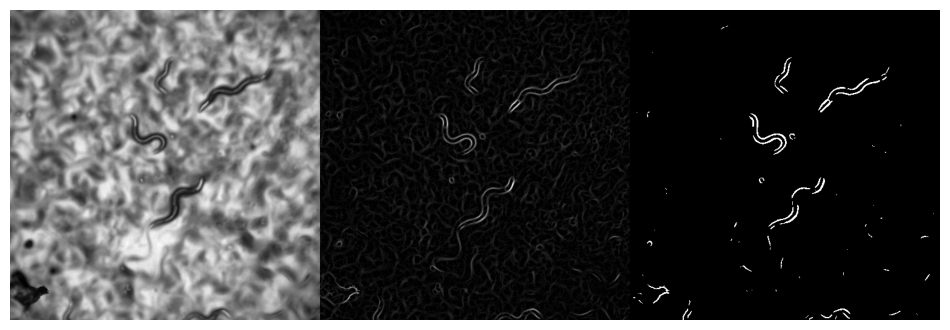

In [145]:
# A built-in skimage filter to detect ridges.
im_sato = skimage.filters.sato(im_dog, sigmas=[0.3, 1], black_ridges=True)
mask = im_sato > (3 * skimage.filters.threshold_otsu(im_sato))
imshow(im, im_sato, mask)

### Background subtraction